# Abstract

First for one simulation output, later, in a different file, for all simulation outputs together:

Input: 
- Network
- Activities from simulation output
- Input Policy

Steps:
1. Create merged dataframe of network and activities
2. Visualize network with the activities
3. Save it in a way that can then be processed by GNN.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from shapely.geometry import box
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

path_to_analysis = "../../../analysis/"

## 1. Load the data
### 1a. and look at population data

In [2]:
population = pd.read_csv(path_to_analysis + "population.csv", sep=";")
network = gpd.read_file(path_to_analysis + "network.gpkg")
activities = gpd.read_file(path_to_analysis + "activities/activities.shp")

In [3]:
print("Population Data:")
print(f"Number of records: {len(population)}")
print(f"Columns: {population.columns.tolist()}")
population.head()

Population Data:
Number of records: 4292
Columns: ['person_id', 'age', 'bikeAvailability', 'carAvailability', 'censusHouseholdId', 'censusPersonId', 'employed', 'hasLicense', 'hasPtSubscription', 'householdId', 'householdIncome', 'htsHouseholdId', 'htsPersonId', 'isOutside', 'isPassenger', 'sex']


,person_id,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isOutside,isPassenger,sex
0,10012156,36,all,all,1612793,3631212,True,yes,True,4440083,2299.690130,805,1616,True,False,f
1,10012879,45,none,some,1612873,3631416,True,yes,False,4440362,351.017365,3409,7917,True,False,m
2,10019087,39,none,all,1613555,3633176,True,yes,False,4442780,1392.941352,1321,2655,True,False,m
3,10032590,24,all,some,1615103,3637093,False,yes,False,4448046,7331.739522,6133,14970,True,True,f
4,10036048,48,some,all,1615462,3638040,True,yes,False,4449344,2669.162060,4717,11250,True,False,m


## 2. Load the network data

In [4]:
print("Network Data:")
print(f"Number of features: {len(network)}")
print(f"CRS: {network.crs}")
network.head()

Network Data:
Number of features: 28384
CRS: EPSG:32633


,link,from,to,osm,lanes,capacity,freespeed,geometry
0,pt_IDFM:463637_375150,pt_IDFM:463637,249742235,NaN,1,9999.0,9.0,"LINESTRING (658414.000 6858068.005, 657550.824..."
1,pt_IDFM:463637,pt_IDFM:463637,pt_IDFM:463637,NaN,1,7999.2,inf,"LINESTRING (658414.000 6858068.005, 658414.000..."
2,pt_IDFM:419004_200246,pt_IDFM:419004,267565737,NaN,1,7999.2,17.0,"LINESTRING (660001.000 6859444.005, 660436.158..."
3,pt_IDFM:419004,pt_IDFM:419004,pt_IDFM:419004,NaN,1,7999.2,inf,"LINESTRING (660001.000 6859444.005, 660001.000..."
4,pt_IDFM:27331_642749,pt_IDFM:27331,5059182780,NaN,1,7999.2,8.0,"LINESTRING (651465.000 6862315.005, 651756.446..."


In [5]:
print("Activities Data:")
print(f"Number of features: {len(activities)}")
print(f"Columns: {activities.columns.tolist()}")
print(type(activities))
print(f"CRS: {activities.crs}")
activities.head()

Activities Data:
Number of features: 39195
Columns: ['personId', 'activityIn', 'type', 'linkId', 'facilityId', 'startTime', 'endTime', 'geometry']
<class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:32633


,personId,activityIn,type,linkId,facilityId,startTime,endTime,geometry
0,8543720,NaN,outside,66857,outside_34,NaN,78815.0,POINT (659868.736 6857568.344)
1,8543720,NaN,outside,38045,outside_22,NaN,20576.0,POINT (650493.325 6857952.579)
2,847828,NaN,outside,23104,outside_325,NaN,56940.0,POINT (648996.233 6858845.328)
3,7326648,NaN,pt interaction,pt_IDFM:22119,NaN,NaN,NaN,POINT (653096.000 6865120.005)
4,7326648,NaN,pt interaction,pt_IDFM:463043,NaN,NaN,NaN,POINT (648358.440 6864110.505)


In [6]:

# Rename the columns to have a common name for merging
gdf_network_renamed = network.rename(columns={'link': 'linkId'})

# Count occurrences of each linkId in the activities geodataframe
activity_counts = activities['linkId'].value_counts().reset_index()
activity_counts.columns = ['linkId', 'activity_count']

# Merge the count with the network geodataframe
gdf_network_with_counts = gdf_network_renamed.merge(activity_counts, on='linkId', how='left')

# Fill NaN values with 0 in the activity_count column
gdf_network_with_counts['activity_count'] = gdf_network_with_counts['activity_count'].fillna(0)

# Merge the network geodataframe (with counts) with the activities geodataframe
merged_gdf = gdf_network_with_counts.merge(activities, on='linkId', how='left', suffixes=('_network', '_activity'))

# Function to check relationships
def check_relationship(row):
    geom_network = row['geometry_network']
    geom_activity = row['geometry_activity']
    
    if pd.isna(geom_activity):
        return 'no_activity'
    elif geom_network.equals(geom_activity):
        return 'equals'
    elif geom_network.intersects(geom_activity):
        return 'intersects'
    elif geom_network.within(geom_activity):
        return 'within'
    elif geom_network.contains(geom_activity):
        return 'contains'
    else:
        return 'disjoint'

# Apply the function to each row
merged_gdf['relationship'] = merged_gdf.apply(check_relationship, axis=1)

# Display the resulting geodataframe
display_columns = ['linkId', 'activity_count', 'relationship']
merged_gdf_display = merged_gdf[display_columns].drop_duplicates()

# If you are using a Jupyter notebook, you can display the DataFrame like this:
merged_gdf_display.head()


,linkId,activity_count,relationship
0,pt_IDFM:463637_375150,0.0,no_activity
1,pt_IDFM:463637,0.0,no_activity
2,pt_IDFM:419004_200246,0.0,no_activity
3,pt_IDFM:419004,2.0,intersects
5,pt_IDFM:27331_642749,0.0,no_activity


In [7]:
merged_gdf_display['activity_count'].describe()

count    28648.000000
mean         1.139661
std          7.838146
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        428.000000
Name: activity_count, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


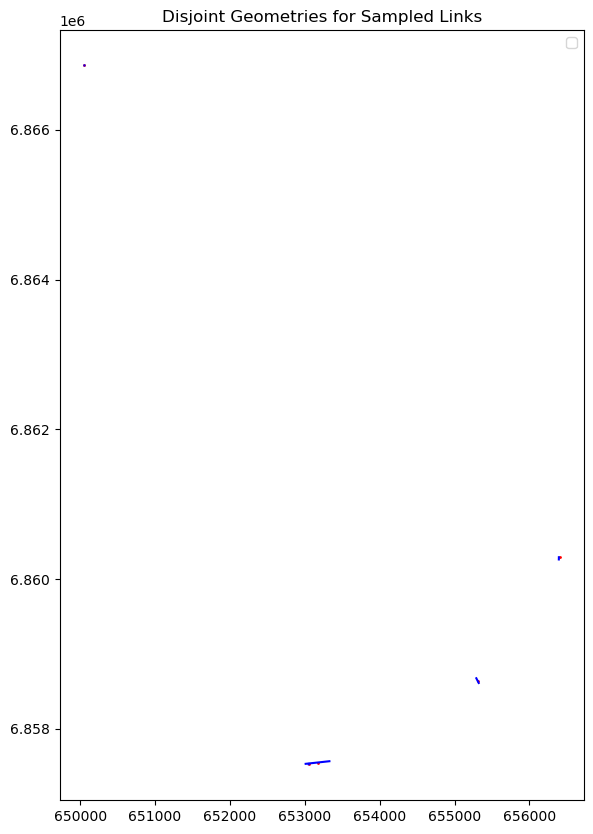

       linkId  activity_count relationship  \
43478   21712            22.0     disjoint   
16418  553120           136.0     disjoint   
4141   695728           334.0     disjoint   
39559  263345             3.0     disjoint   
26867  418736            80.0     disjoint   

                                        geometry_network  \
43478  LINESTRING (650070.806 6866857.742, 650043.680...   
16418  LINESTRING (655284.904 6858686.772, 655329.167...   
4141   LINESTRING (652997.865 6857530.076, 653342.835...   
39559  LINESTRING (656392.819 6860247.205, 656393.972...   
26867  LINESTRING (653054.536 6857512.248, 653048.161...   

                    geometry_activity  
43478  POINT (650057.243 6866859.489)  
16418  POINT (655307.036 6858642.918)  
4141   POINT (653170.350 6857549.015)  
39559  POINT (656408.420 6860298.620)  
26867  POINT (653051.348 6857528.091)  


In [8]:
# Rename the columns to have a common name for merging
gdf_network_renamed = network.rename(columns={'link': 'linkId'})

# Count occurrences of each linkId in the activities geodataframe
activity_counts = activities['linkId'].value_counts().reset_index()
activity_counts.columns = ['linkId', 'activity_count']

# Merge the count with the network geodataframe
gdf_network_with_counts = gdf_network_renamed.merge(activity_counts, on='linkId', how='left')

# Fill NaN values with 0 in the activity_count column
gdf_network_with_counts['activity_count'] = gdf_network_with_counts['activity_count'].fillna(0)

# Merge the network geodataframe (with counts) with the activities geodataframe
merged_gdf = gdf_network_with_counts.merge(activities, on='linkId', how='left', suffixes=('_network', '_activity'))

# Function to check relationships
def check_relationship(row):
    geom_network = row['geometry_network']
    geom_activity = row['geometry_activity']
    
    if pd.isna(geom_activity):
        return 'no_activity'
    elif geom_network.equals(geom_activity):
        return 'equals'
    elif geom_network.intersects(geom_activity):
        return 'intersects'
    elif geom_network.within(geom_activity):
        return 'within'
    elif geom_network.contains(geom_activity):
        return 'contains'
    else:
        return 'disjoint'

# Apply the function to each row
merged_gdf['relationship'] = merged_gdf.apply(check_relationship, axis=1)

# Filter the dataframe for disjoint relationships
disjoint_gdf = merged_gdf[merged_gdf['relationship'] == 'disjoint']

# Select 5 random disjoint links for plotting
sample_disjoint_links = disjoint_gdf.sample(n=5, random_state=1)

# Plot the geometries for the selected disjoint links
fig, ax = plt.subplots(figsize=(10, 10))

for idx, row in sample_disjoint_links.iterrows():
    # Create GeoDataFrames for the geometries
    gdf_network_geom = gpd.GeoDataFrame(index=[0], crs=network.crs, geometry=[row['geometry_network']])
    gdf_activity_geom = gpd.GeoDataFrame(index=[0], crs=activities.crs, geometry=[row['geometry_activity']])
    
    # Plot the geometries
    gdf_network_geom.plot(ax=ax, color='blue', label='Network Geometry' if idx == 0 else "")
    gdf_activity_geom.plot(ax=ax, color='red', label='Activity Geometry' if idx == 0 else "", markersize=1)

plt.legend()
plt.title('Disjoint Geometries for Sampled Links')
plt.show()

# Display the sample disjoint links dataframe
sample_disjoint_links_display = sample_disjoint_links[['linkId', 'activity_count', 'relationship', 'geometry_network', 'geometry_activity']]
print(sample_disjoint_links_display)

In [9]:
# Rename the columns to have a common name for merging
network_renamed = network.rename(columns={'link': 'linkId'})
activities_renamed = activities.rename(columns={'linkId': 'linkId'})

# Group activities by linkId and combine their geometries into a list
activities_grouped = activities_renamed.groupby('linkId')['geometry'].apply(list).reset_index()
activities_grouped.columns = ['linkId', 'geometry_activity']

# Count occurrences of each linkId in the activities geodataframe
activity_counts = activities_renamed['linkId'].value_counts().reset_index()
activity_counts.columns = ['linkId', 'activity_count']

# Merge the count and geometries with the network geodataframe
links_all = network_renamed.merge(activity_counts, on='linkId', how='left')
links_all = links_all.merge(activities_grouped, on='linkId', how='left')

# Fill NaN values with 0 in the activity_count column and empty lists in the geometry_activity column
links_all['activity_count'] = links_all['activity_count'].fillna(0)
links_all['geometry_activity'] = links_all['geometry_activity'].apply(lambda x: x if isinstance(x, list) else [])

# Rename the geometry column in the network dataframe for clarity
links_all = links_all.rename(columns={'geometry': 'geometry_network'})

# Function to check relationships and calculate distance if disjoint
def check_relationship(row):
    geom_network = row['geometry_network']
    geom_activity_list = row['geometry_activity']
    
    if not geom_activity_list:
        return 'no_activity', None
    
    disjoint = True
    min_distance = float('inf')
    
    for geom_activity in geom_activity_list:
        if geom_network.equals(geom_activity):
            disjoint = False
            return 'equals', 0
        elif geom_network.intersects(geom_activity):
            disjoint = False
            return 'intersects', 0
        elif geom_network.within(geom_activity):
            disjoint = False
            return 'within', 0
        elif geom_network.contains(geom_activity):
            disjoint = False
            return 'contains', 0
        else:
            distance = geom_network.distance(geom_activity)
            if distance < min_distance:
                min_distance = distance
    
    if disjoint:
        return 'disjoint', min_distance

# Apply the function to each row
links_all['relationship'], links_all['distance'] = zip(*links_all.apply(check_relationship, axis=1))

# Apply the function to each row
links_all['relationship'], links_all['distance'] = zip(*links_all.apply(check_relationship, axis=1))

# # Convert the distance to meters (since the CRS is EPSG:32633, the distance is already in meters)
# network_with_counts['distance in meters'] = network_with_counts['distance']

# Format the distance in meters to be more readable
links_all['distance in meters'] = links_all['distance'].apply(lambda x: '{:.2f}'.format(x) if x is not None else x)

# Drop the 'shortest_distance' column
links_all = links_all.drop(columns=['shortest_distance'], errors='ignore')

# Filter the network_with_counts GeoDataFrame for rows where geometry_activity is not an empty list
links_with_activity = links_all[links_all['geometry_activity'].apply(lambda x: len(x) > 0)]

# Display the first 20 rows of the filtered GeoDataFrame
links_with_activity.head(20)

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


,linkId,from,to,osm,lanes,capacity,freespeed,geometry_network,activity_count,geometry_activity,relationship,distance,distance in meters
3,pt_IDFM:419004,pt_IDFM:419004,pt_IDFM:419004,NaN,1,7999.2,inf,"LINESTRING (660001.000 6859444.005, 660001.000...",2.0,"[POINT (660001.0000320164 6859444.004639416), ...",intersects,0.000000e+00,0.00
66,99641,14803153,14803155,primary,3,3600.0,13.888889,"LINESTRING (643834.520 6863045.677, 643898.380...",9.0,"[POINT (643870.0000449368 6863006.004637466), ...",disjoint,3.801817e-10,0.00
73,99554,259647309,3745434655,primary,2,2400.0,13.888889,"LINESTRING (653451.395 6858017.576, 653611.008...",6.0,"[POINT (653501.9927840339 6858041.915019131), ...",disjoint,8.127545e-11,0.00
74,9954,2499759203,271468595,unclassified,1,480.0,8.333333,"LINESTRING (645357.396 6863157.425, 645733.259...",1.0,[POINT (645519.9 6863097)],disjoint,3.976883e+01,39.77
89,99170,24965951,24965958,residential,1,480.0,8.333333,"LINESTRING (650814.371 6860505.920, 650926.516...",1.0,[POINT (650864.42 6860514.48)],disjoint,1.781600e+01,17.82
92,99121,24984516,24984411,residential,1,480.0,8.333333,"LINESTRING (651461.508 6860573.265, 651378.700...",1.0,[POINT (651421.5 6860580.5)],disjoint,5.767411e+00,5.77
93,99119,317716023,24965996,residential,1,480.0,8.333333,"LINESTRING (651040.500 6860688.838, 651305.060...",1.0,[POINT (651079.0000391605 6860680.004638734)],disjoint,6.890598e+00,6.89
94,99118,24965996,317716023,residential,1,480.0,8.333333,"LINESTRING (651305.060 6860675.545, 651040.500...",1.0,[POINT (651191.2 6860688)],disjoint,6.725285e+00,6.73
97,99113,24965991,24966019,residential,1,480.0,8.333333,"LINESTRING (651294.757 6860481.870, 651291.420...",1.0,[POINT (651270.1 6860471)],disjoint,2.406965e+01,24.07
98,99112,24965996,24965991,residential,1,480.0,8.333333,"LINESTRING (651305.060 6860675.545, 651294.757...",4.0,"[POINT (651293 6860579), POINT (651299.9048604...",disjoint,2.673279e-11,0.00


In [10]:
len(links_with_activity)

5331

In [11]:
len(links_all)

28384

## Merged geodataframe

By merging the dataframes, we know on which links there has been activity and on which there hasn't. Our networks has size 28384. Network with links, on which an activity has happened has size 5331. 

Let us plot this. 

In [15]:
links_all.set_geometry('geometry_network', inplace=True)

In [16]:
links_all.head()

,linkId,from,to,osm,lanes,capacity,freespeed,geometry_network,activity_count,geometry_activity,relationship,distance,distance in meters
0,pt_IDFM:463637_375150,pt_IDFM:463637,249742235,NaN,1,9999.0,9.0,"LINESTRING (658414.000 6858068.005, 657550.824...",0.0,[],no_activity,NaN,nan
1,pt_IDFM:463637,pt_IDFM:463637,pt_IDFM:463637,NaN,1,7999.2,inf,"LINESTRING (658414.000 6858068.005, 658414.000...",0.0,[],no_activity,NaN,nan
2,pt_IDFM:419004_200246,pt_IDFM:419004,267565737,NaN,1,7999.2,17.0,"LINESTRING (660001.000 6859444.005, 660436.158...",0.0,[],no_activity,NaN,nan
3,pt_IDFM:419004,pt_IDFM:419004,pt_IDFM:419004,NaN,1,7999.2,inf,"LINESTRING (660001.000 6859444.005, 660001.000...",2.0,"[POINT (660001.0000320164 6859444.004639416), ...",intersects,0.0,0.00
4,pt_IDFM:27331_642749,pt_IDFM:27331,5059182780,NaN,1,7999.2,8.0,"LINESTRING (651465.000 6862315.005, 651756.446...",0.0,[],no_activity,NaN,nan


In [18]:
links_all.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
links_all.set_crs(epsg=2154, inplace=True, allow_override=True)
links_with_activity = links_with_activity.set_crs(epsg=2154, inplace=True, allow_override=True)


In [21]:
links_all.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
districts = gpd.read_file("../../../data/visualisation/districts_paris.geojson")

In [16]:
districts

,c_ar,surface,perimetre,geometry
0,1,1.824613e+06,6054.936862,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,2,9.911537e+05,4554.104360,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
2,3,1.170883e+06,4519.263648,"POLYGON ((2.36383 48.86750, 2.36389 48.86747, ..."
3,4,1.600586e+06,5420.908434,"POLYGON ((2.36851 48.85573, 2.36900 48.85374, ..."
4,5,2.539375e+06,6239.195396,"POLYGON ((2.36443 48.84614, 2.36484 48.84584, ..."
5,6,2.153096e+06,6483.686786,"POLYGON ((2.34459 48.85405, 2.34428 48.85375, ..."
6,7,4.090057e+06,8099.424883,"POLYGON ((2.32090 48.86306, 2.32094 48.86305, ..."
7,8,3.880036e+06,7880.533268,"POLYGON ((2.32584 48.86956, 2.32569 48.86954, ..."
8,9,2.178303e+06,6471.588290,"POLYGON ((2.33978 48.88203, 2.33982 48.88202, ..."
9,10,2.891739e+06,6739.375055,"POLYGON ((2.36469 48.88437, 2.36485 48.88436, ..."


In [17]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Load your GeoDataFrame (assuming you already have it loaded as 'districts')
# # Example: districts = gpd.read_file('path_to_your_file.shp')

# # Check the initial CRS
# print(f"Initial CRS: {districts.crs}")

# # If the initial CRS is not set, you need to set it manually.
# # For example, if you know the initial CRS is EPSG:4326 (WGS 84), set it like this:
# if districts.crs is None:
#     districts.set_crs(epsg=4326, inplace=True)  # Set to the correct CRS if known

# # Now convert the GeoDataFrame to CRS EPSG:32633
# districts = districts.to_crs(epsg=32633)

# # Verify the CRS conversion
# print(f"Converted CRS: {districts.crs}")

# # Plot the districts
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# districts.plot(ax=ax, edgecolor='k', facecolor='none')  # edgecolor for borders, facecolor for fill

# # Optionally, set the title and axis labels
# ax.set_title('Districts Map (EPSG:32633)')
# ax.set_xlabel('Easting (meters)')
# ax.set_ylabel('Northing (meters)')

# plt.show()


In [18]:
districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

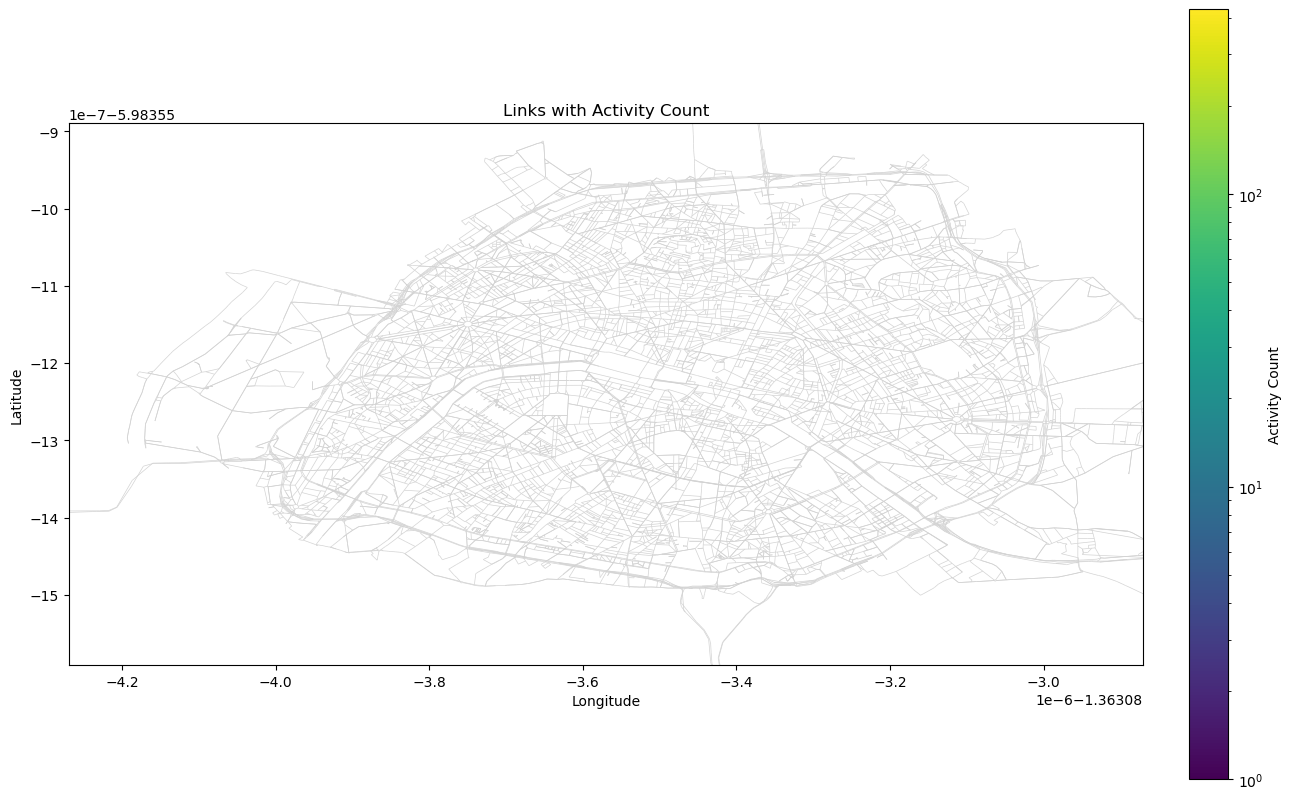

In [25]:
# Set the 'geometry_network' as the active geometry column
links_with_activity = links_with_activity.set_geometry('geometry_network')
links_all = links_all.set_geometry('geometry_network')

# Ensure that both GeoDataFrames use the same CRS
links_with_activity = links_with_activity.to_crs(epsg=4326)
links_all = links_all.to_crs(epsg=4326)

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot all links in grey
links_all.plot(ax=ax, color='lightgrey', linewidth=0.5)

# Get the range of activity_count for normalization
min_activity_count = links_with_activity['activity_count'].min()
max_activity_count = links_with_activity['activity_count'].max()

# Normalize the activity_count using LogNorm for the colormap
norm = mcolors.LogNorm(vmin=max(min_activity_count, 1), vmax=max_activity_count)

# Create a colormap
cmap = cm.viridis

# Plot links_with_activity with the colormap based on activity_count
links_with_activity.plot(
    ax=ax, 
    column='activity_count', 
    cmap=cmap, 
    linewidth=1,  # thicker lines for better visibility
    norm=norm,
    legend=False  # Disable the default legend
)

# Set plot title
ax.set_title('Links with Activity Count')

# Adjust the plot limits to zoom in more on the upper part
xlim = (links_all.total_bounds[0], links_all.total_bounds[2])
ylim = (links_all.total_bounds[1], links_all.total_bounds[3])
ax.set_xlim(xlim[0] + (xlim[1] - xlim[0]) / 6, xlim[1] - (xlim[1] - xlim[0]) / 6)
ax.set_ylim(ylim[0] + (ylim[1] - ylim[0]) / 4, ylim[1] - (ylim[1] - ylim[0]) / 12)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')   
# Add a vertical colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Activity Count')

plt.show()